# Bayesian Methods for Estimating Early Season wOBA

**Author**: Jensen Holm <br>
**Date**: April 2025 <br>

In [1]:
import statcast_pitches
import holm_ggtheme
from plotnine import *
import polars as pl

## Importing Data & EDA

Early on in the MLB season, statistics like wOBA (weighted on base average) can be all over the place due to small sample sizes. But we can use bayesian methods to estimate a players 'true' wOBA with a small sample size, using our prior knowledge of xwOBA as our prior.

```math
wOBA = \frac{IBB_w \times IBB + HBP_w \times HBP + 1B_w \times 1B + 2B_w \times 2B + 3B_w \times 3B + HR_w \times HR}{AB + IBB + SF + HBP}
```

Where ...
- $X_w$: $w$ subscript indicates adjusted run expectancy for that batting event in the context of a particular season

Each *batted ball* in the statcast_pitches dataframe has an associated wOBA value based on the result of that play. So all I have to do initially is average this number for each player.

In [2]:
woba_df: pl.DataFrame = (statcast_pitches.load()
                            .filter(pl.col('game_year').is_in([2023, 2024, 2025]))
                            .group_by('batter', 'game_year')
                            .agg(pl.col('woba_value').mean().alias('woba'),
                                 pl.len().alias("pitches_seen"))
                            .drop_nulls()
                            .with_columns(pl.col('game_year').cast(pl.Utf8)) # game_year should be categorical
                            .collect())

print(woba_df.describe())

shape: (9, 5)
┌────────────┬───────────────┬───────────┬──────────┬──────────────┐
│ statistic  ┆ batter        ┆ game_year ┆ woba     ┆ pitches_seen │
│ ---        ┆ ---           ┆ ---       ┆ ---      ┆ ---          │
│ str        ┆ f64           ┆ str       ┆ f64      ┆ f64          │
╞════════════╪═══════════════╪═══════════╪══════════╪══════════════╡
│ count      ┆ 4315.0        ┆ 4315      ┆ 4315.0   ┆ 4315.0       │
│ null_count ┆ 0.0           ┆ 0         ┆ 0.0      ┆ 0.0          │
│ mean       ┆ 673441.836848 ┆ null      ┆ 0.298868 ┆ 379.0927     │
│ std        ┆ 57626.426556  ┆ null      ┆ 0.252883 ┆ 710.913623   │
│ min        ┆ 408234.0      ┆ 2023      ┆ 0.0      ┆ 1.0          │
│ 25%        ┆ 663411.0      ┆ null      ┆ 0.135556 ┆ 8.0          │
│ 50%        ┆ 677565.0      ┆ null      ┆ 0.2997   ┆ 30.0         │
│ 75%        ┆ 690984.0      ┆ null      ┆ 0.38     ┆ 256.0        │
│ max        ┆ 828599.0      ┆ 2025      ┆ 2.0      ┆ 3651.0       │
└────────────┴──────

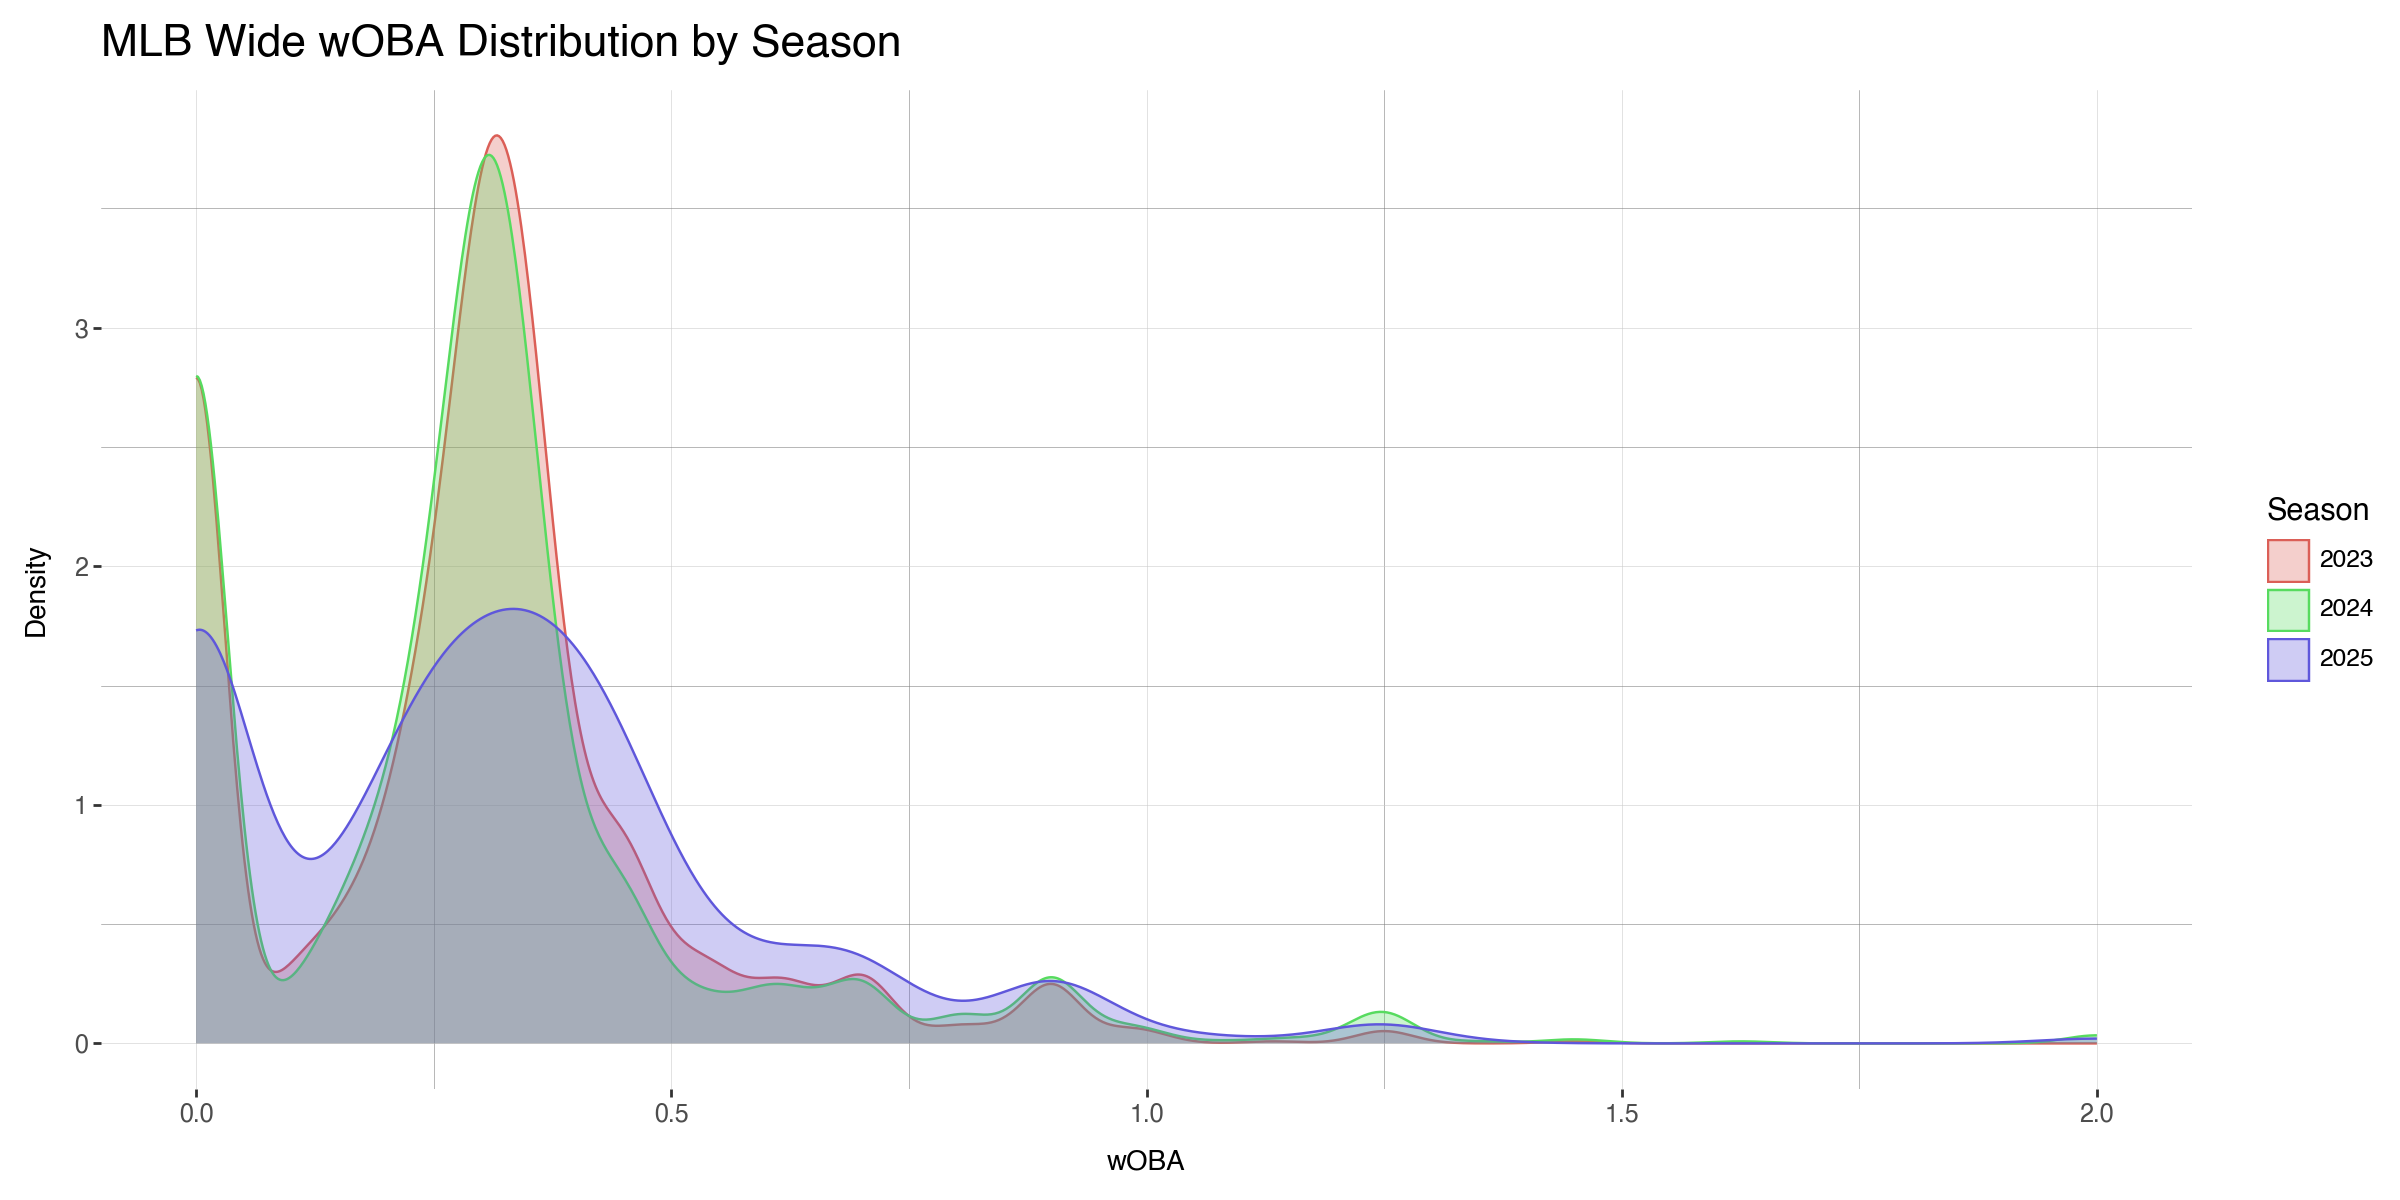

In [ ]:
# plot the distribution of wOBA in 2023 & 2024
prior_dists_plot = (
    ggplot(woba_df, aes(x='woba', fill='game_year', color='game_year'))
    + geom_density(alpha=0.3)
    # + facet_wrap('~game_year')
    + holm_ggtheme.base(figure_size=(12, 6))
    + labs(title='MLB Wide wOBA Distribution by Season', x='wOBA', y='Density', 
           fill='Season', color='Season')
)

prior_dists_plot.show()